# Gaussianization Model

In [17]:
import sys
from pyprojroot import here

sys.path.append(str(here()))

# RBIG Packages
from rbig.data import ToyData
from rbig.layers import RBIGLayer

# import RBIG Layer
from rbig.layers.rbig_layer import RBIGLayer
from rbig.stopping import InfoLoss, MaxLayers
from rbig.transform.gaussianization import MarginalGaussianization
from rbig.transform.uniformization import KDEUniformization, HistogramUniformization
from rbig.transform.linear import OrthogonalTransform
from rbig.models import GaussianizationModel, RBIG

from typing import Iterable, Optional, Dict, NamedTuple, Tuple, Union
import numpy as np

import numpy as np
from scipy import stats

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1. Marginal Uni
2. Inverse CDF Gauss

1:
* Histogram
* KDE
* Mixture Dist

1 + 2:
* Quantiles
* ...

## Data

In [2]:
def plot_2d_joint(data, color='blue', title='Original Data'):
    
    fig  = plt.figure(figsize=(5, 5))

    g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', color=color)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_prob(data, probs, title='Probabilities'):
    
    fig, ax = plt.subplots()

    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap='Reds')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = plt.colorbar(h, )
    ax.set_title(title)
    plt.show()

<Figure size 360x360 with 0 Axes>

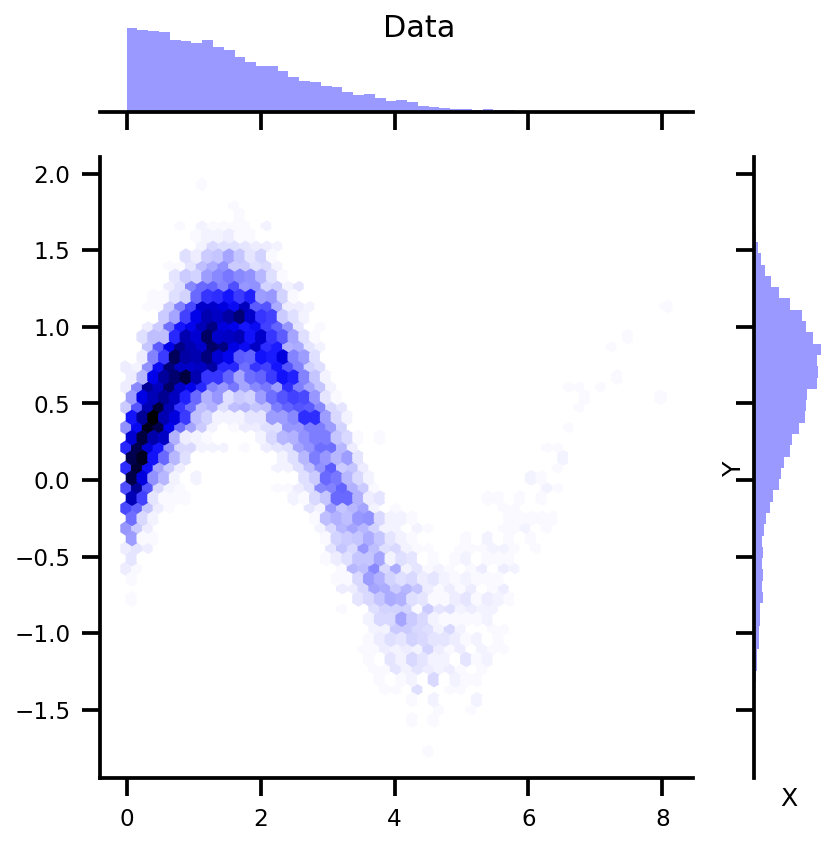

In [18]:
seed = 123
rng = np.random.RandomState(seed=seed)
dataset = 'rbig'
n_samples = 10_000
n_features = 2
noise = 0.25
random_state=1
clusters = 2


data = ToyData(
    dataset=dataset, 
    n_samples=n_samples, 
    n_features=n_features, 
    noise=noise, 
    random_state=random_state,
    clusters=clusters,
).generate_samples()

plot_2d_joint(data, title='Data')

## RBIG Layers

An `RBIGLayer` is a block represents the sequence of RBIG Transforms:

1. Marginal Gaussianization Transformation
2. Rotation Transformation

You need to pick two components and then initialize an RBIG Layer. For this example, we'll show it using the Histogram transformation but any method within the package. Current methods available:

* Histogram
* KDE (Exact, FFT)
* Quantile

In [19]:
# Step 1 - Pick a Uniformization Transformer
uniform_clf = HistogramUniformization(bins=50, support_extension=10, alpha=1e-4, n_quantiles=None)
# uniform_clf = KDEUniformization(n_quantiles=50, method='fft', )
# gauss_clf = Gaussianizatio
mg_gaussianization = MarginalGaussianization(uniform_clf)

# Step 3 - Pick Rotation transformer
orth_transform = OrthogonalTransform('pca')

# Step 4 - Initialize RBIG Block
rbig_block = RBIGLayer(mg_gaussianization, orth_transform)

In [20]:
X_trans = rbig_block.transform(data)

<Figure size 360x360 with 0 Axes>

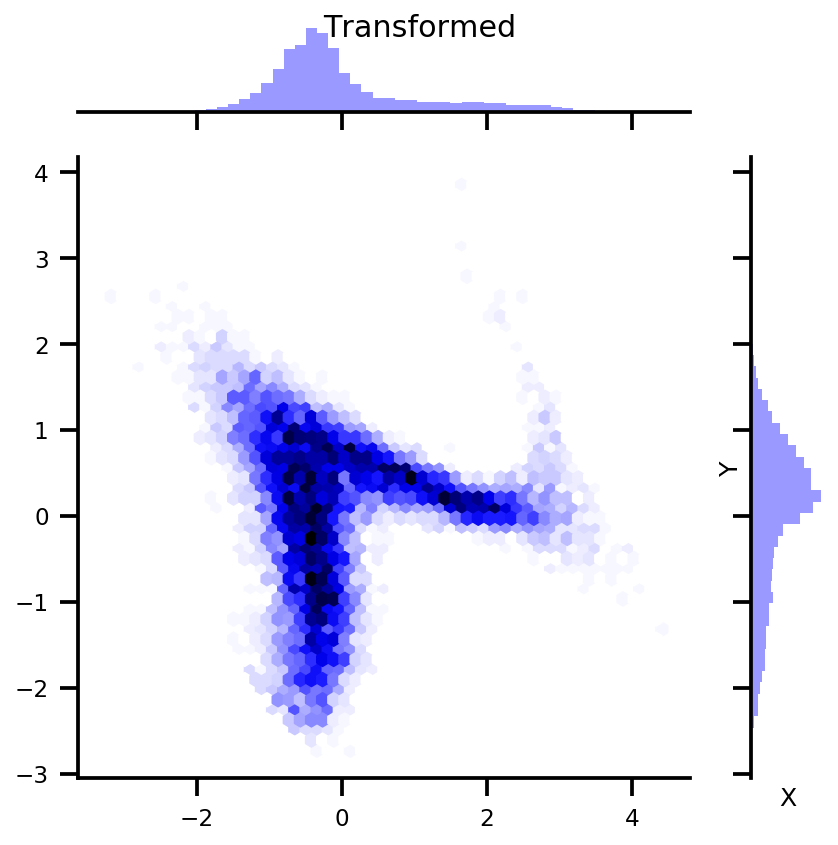

<Figure size 360x360 with 0 Axes>

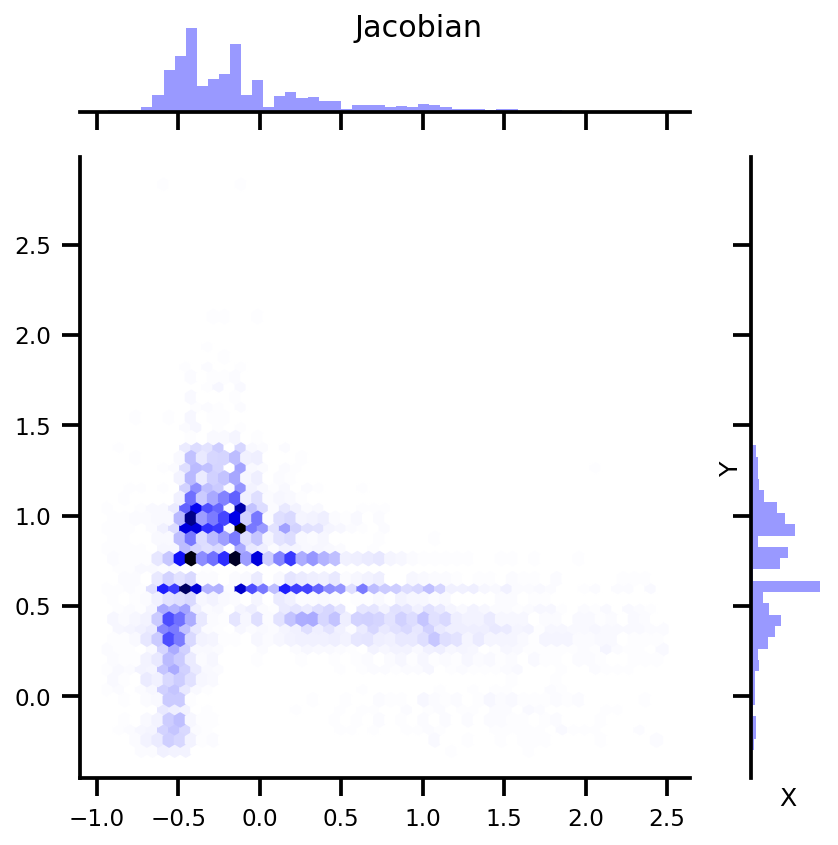

In [21]:
X_trans, dX_trans = rbig_block.transform(data, return_jacobian=True)

plot_2d_joint(X_trans, title='Transformed')
plot_2d_joint(dX_trans, title='Jacobian')

<Figure size 360x360 with 0 Axes>

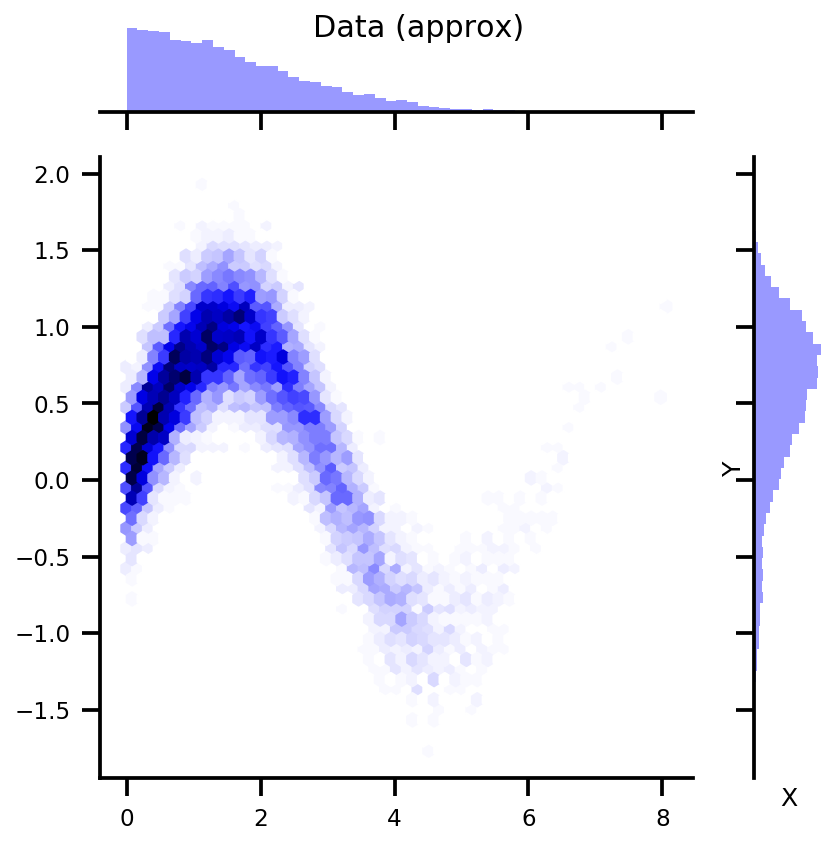

In [22]:
data_approx = rbig_block.inverse_transform(X_trans)
plot_2d_joint(data_approx, title='Data (approx)')

## 2. Multiple Layers

When dealing with multiple layers, we need to initialize a `GaussanizationModel` with the following components:

1. `RBIGLayer` as we have seen above
2. `StoppingCriteria`

As this is an iterative model, we need some sort of stopping criteria to ensure we converge. Without an appropriate stopping criteria, this method will not converge as it won't be able to distinguish between noise and information. So let's go over 2 easy stopping criteria that have already been implemented:

* `MaxLayer` - this simply states the maximum number of layers to use.
* `InfoLoss` - this calculates the difference in total correlation between layers from the original RBIG paper.

we will do a demonstration using both methods.

In [234]:
from rbig.stopping import NegEntropyLoss

In [34]:
%%timeit
# Step 1 - Pick a Uniformization Transformer
uniform_clf = HistogramUniformization(bins=50, support_extension=10, alpha=1e-4, n_quantiles=None)
# uniform_clf = KDEUniformization(n_quantiles=50, method='exact', )
# Step 1 - Pick a Uniformization Transformer
# uniform_clf = HistogramUniformization(bins=100, support_extension=10, alpha=1e-4, n_quantiles=None)
# uniform_clf = KDEUniformization(n_quantiles=50, method='fft', )
# Step 2 - Initialize Marginal Gaussianization Transformer
mg_gaussianization = MarginalGaussianization(uniform_clf)


# Step 3 - Pick Rotation transformer
orth_transform = OrthogonalTransform('pca')

# Step 4 - Initialize RBIG Block
rbig_block = RBIGLayer(mg_gaussianization, orth_transform)

# Step 5 - Initialize loss function
# rbig_loss = MaxLayers(n_layers=50)
rbig_loss = InfoLoss(tol_layers=10, method='histogram', p_value=0.25)
# rbig_loss = NegEntropyLoss()
# Step 6 - Intialize Gaussianization Model
rbig_model = RBIG(rbig_block, rbig_loss, verbose=False)

6.97 µs ± 317 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [36]:
%%timeit
# Step 1 - Pick a Uniformization Transformer
uniform_clf = HistogramUniformization(bins=50, support_extension=10, alpha=1e-4, n_quantiles=None)
# uniform_clf = KDEUniformization(n_quantiles=50, method='exact', )
# Step 1 - Pick a Uniformization Transformer
# uniform_clf = HistogramUniformization(bins=100, support_extension=10, alpha=1e-4, n_quantiles=None)
# uniform_clf = KDEUniformization(n_quantiles=50, method='fft', )
# Step 2 - Initialize Marginal Gaussianization Transformer
mg_gaussianization = MarginalGaussianization(uniform_clf)


# Step 3 - Pick Rotation transformer
orth_transform = OrthogonalTransform('pca')

# Step 4 - Initialize RBIG Block
rbig_block = RBIGLayer(mg_gaussianization, orth_transform)

# Step 5 - Initialize loss function
# rbig_loss = MaxLayers(n_layers=50)
rbig_loss = InfoLoss(tol_layers=10, method='histogram', p_value=0.25)
# rbig_loss = NegEntropyLoss()
# Step 6 - Intialize Gaussianization Model
rbig_model = GaussianizationModel(rbig_block, rbig_loss, verbose=False)

6.08 µs ± 2.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [23]:
# Step 1 - Pick a Uniformization Transformer
uniform_clf = HistogramUniformization(bins=50, support_extension=10, alpha=1e-4, n_quantiles=None)
# uniform_clf = KDEUniformization(n_quantiles=50, method='exact', )
# Step 1 - Pick a Uniformization Transformer
# uniform_clf = HistogramUniformization(bins=100, support_extension=10, alpha=1e-4, n_quantiles=None)
# uniform_clf = KDEUniformization(n_quantiles=50, method='fft', )
# Step 2 - Initialize Marginal Gaussianization Transformer
mg_gaussianization = MarginalGaussianization(uniform_clf)


# Step 3 - Pick Rotation transformer
orth_transform = OrthogonalTransform('pca')

# Step 4 - Initialize RBIG Block
rbig_block = RBIGLayer(mg_gaussianization, orth_transform)

# Step 5 - Initialize loss function
# rbig_loss = MaxLayers(n_layers=50)
rbig_loss = InfoLoss(tol_layers=10, method='histogram', p_value=0.25)
# rbig_loss = NegEntropyLoss()
# Step 6 - Intialize Gaussianization Model
rbig_model = RBIG(rbig_block, rbig_loss, verbose=False)

In [24]:
# fit model to data
rbig_model.fit(data);

In [25]:
rbig_model.total_correlation()

0.687664202770911

In [26]:
len(rbig_model.flows_)

13

### Viz - Forward Transformation, Latent Space Z

<Figure size 360x360 with 0 Axes>

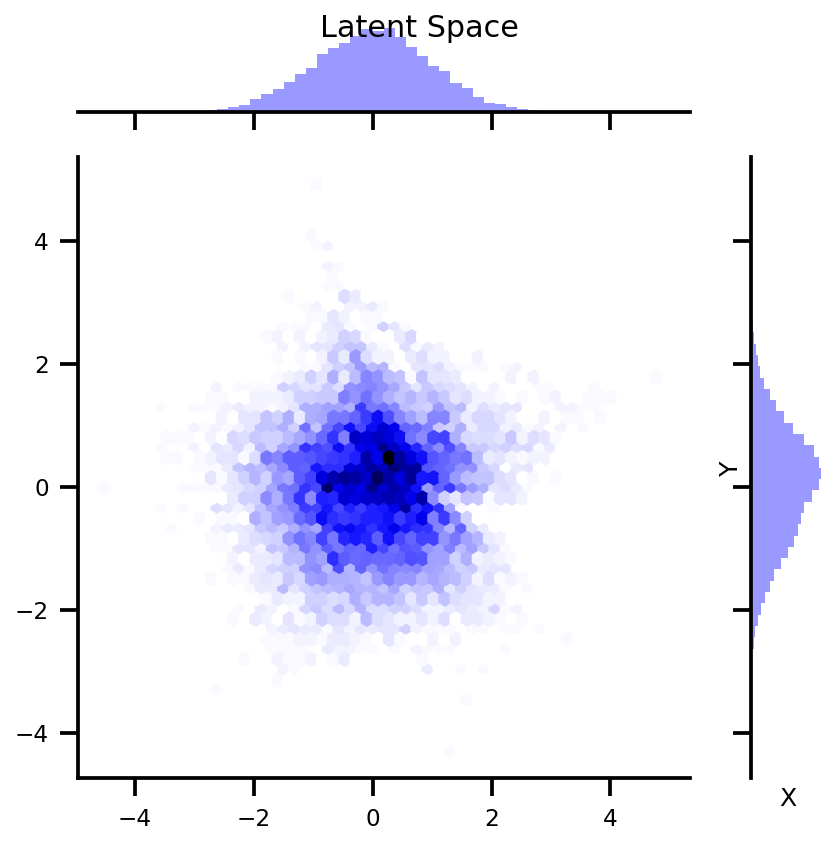

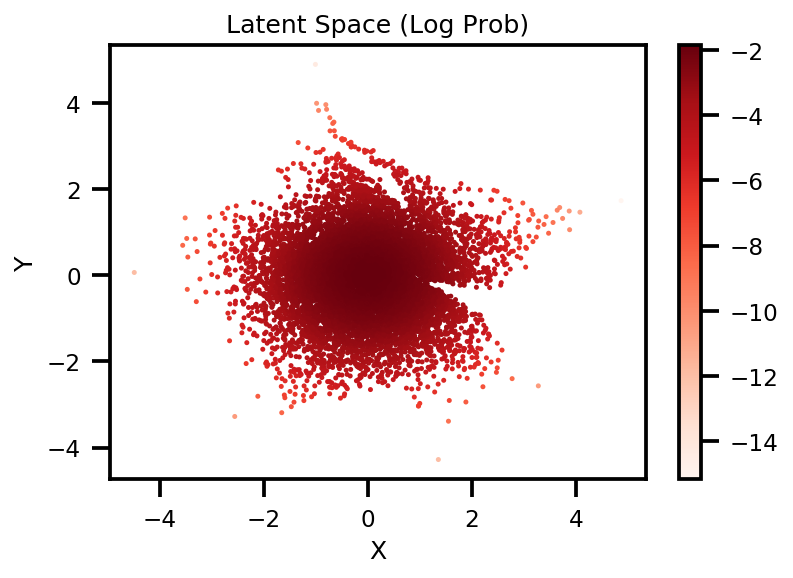

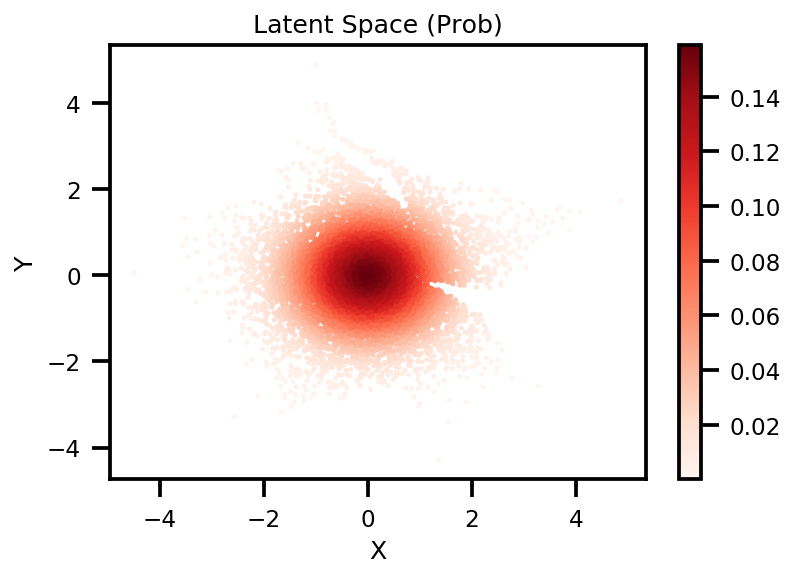

In [27]:
Z, X_slogdzet = rbig_model.transform(data)
plot_2d_joint(Z, title='Latent Space')

X_priorprob = stats.norm().logpdf(Z)


plot_prob(Z, X_priorprob.sum(axis=1), title='Latent Space (Log Prob)')
plot_prob(Z, np.exp(X_priorprob.sum(axis=1)), title='Latent Space (Prob)')

### Viz - Inverse Transformation, Data Space X

<Figure size 360x360 with 0 Axes>

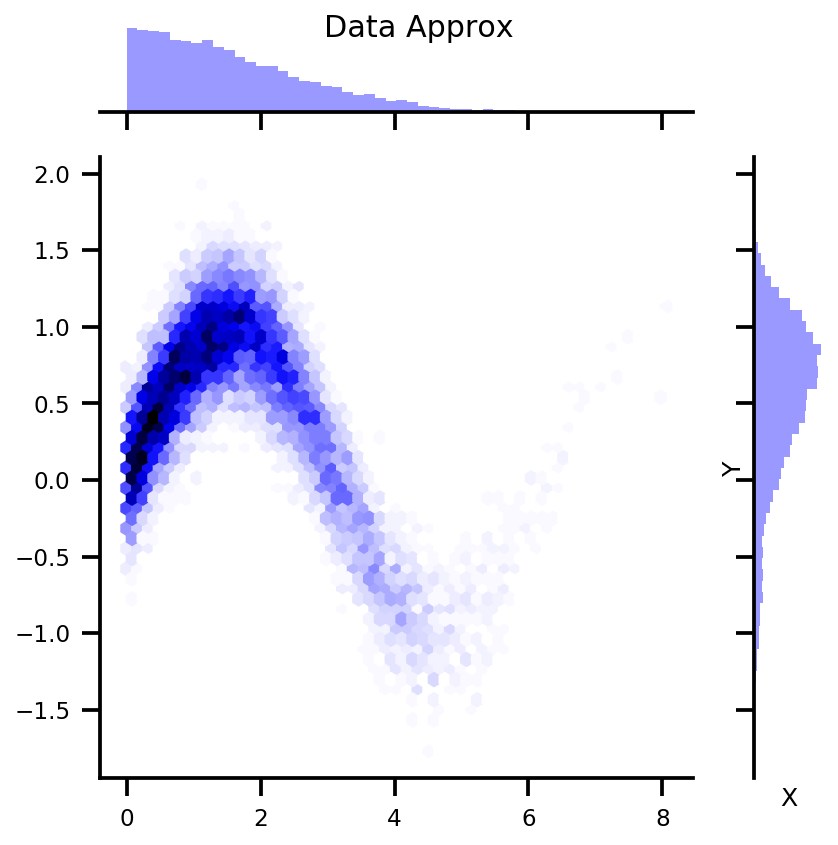

In [28]:
data_approx = rbig_model.inverse_transform(Z)
plot_2d_joint(data_approx, title='Data Approx')

### Viz - Sampling, Data Space X

<Figure size 360x360 with 0 Axes>

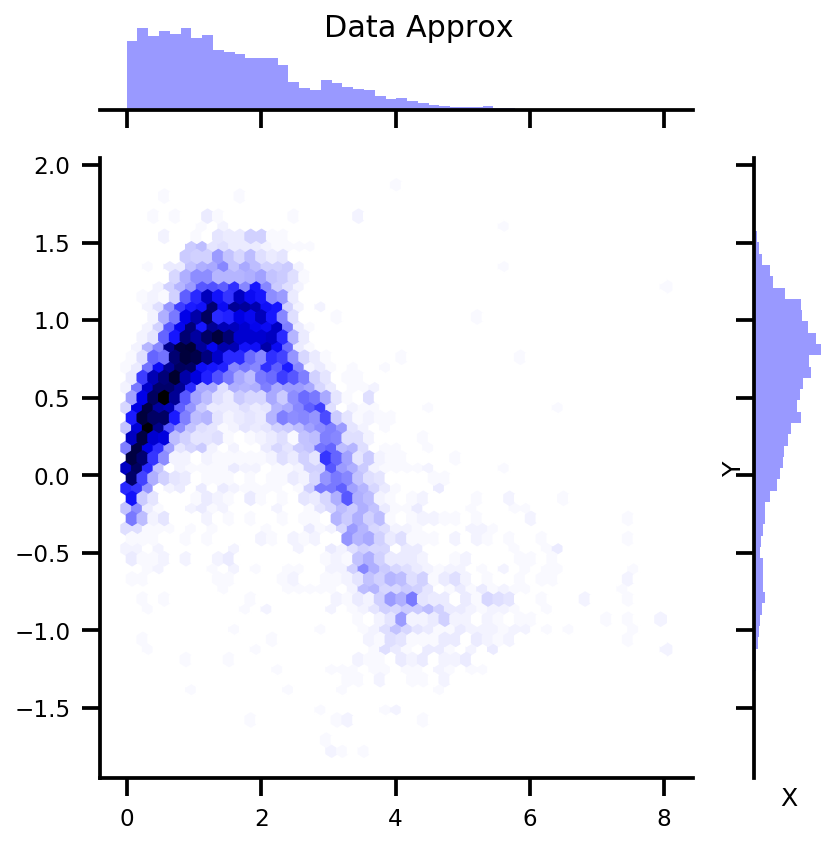

In [29]:
data_approx = rbig_model.sample(10_000)
plot_2d_joint(data_approx, title='Data Approx')

### Viz - Probabilities, Data Space X

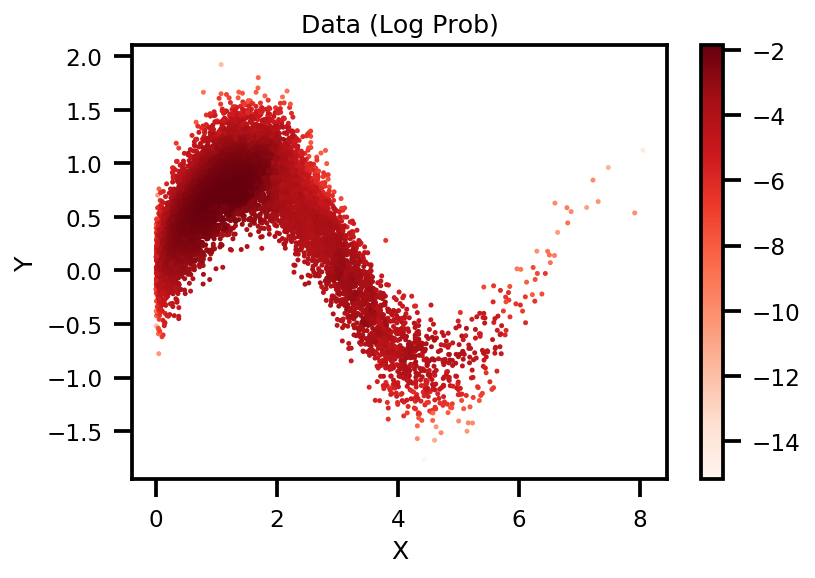

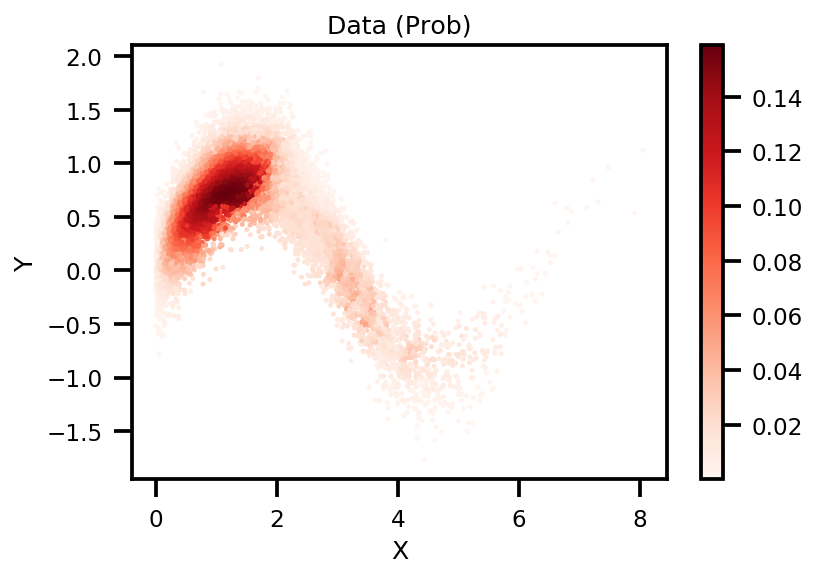

In [30]:
X_prob = rbig_model.score_samples(data)

plot_prob(data, X_prob, title='Data (Log Prob)')
plot_prob(data, np.exp(X_prob), title='Data (Prob)')

In [31]:
X_nll = rbig_model.score(data, None)
print('Negative Log-Likelihood:',X_nll)
print('Negative Likelihood:',np.exp(X_nll))

Negative Log-Likelihood: -3.2745303123926837
Negative Likelihood: 0.037834635516125356


In [191]:
X_nll = rbig_model.score(data, None)
print('Negative Log-Likelihood:',X_nll)
print('Negative Likelihood:',np.exp(X_nll))

Negative Log-Likelihood: -3.3359464059042327
Negative Likelihood: 0.035580896301384106


### Viz - Negative Log-Likelihood

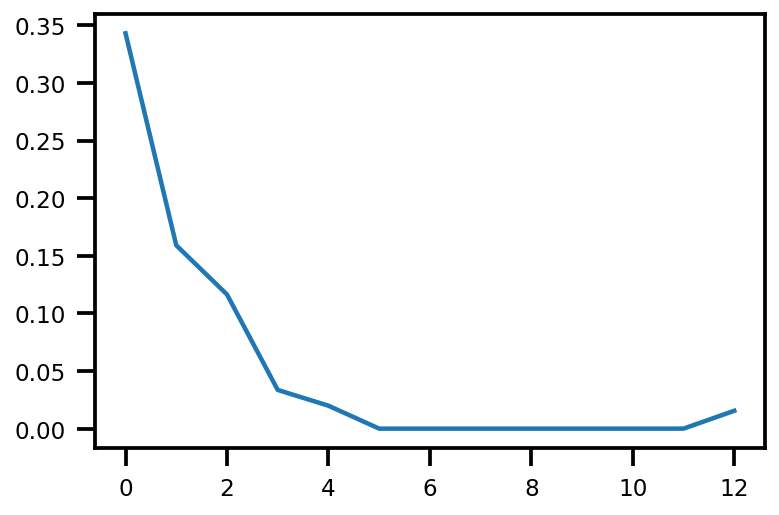

In [32]:
plt.plot(rbig_model.losses_)